## Electrical Element Detector ##

First, I want to make using tensorflow an image classifier that seperates different electrical elements. After that, I plan to use the model in different applications. 
So, let's begin


So first, I will install my libraries that I will be using. It is important to note that I am using a virtual environment as I am using several versions of Python on my laptop and I will find it easy to depict with certainty the python and pip I am using with a virtual environment


In [264]:
!pip install opencv-python tensorflow matplotlib

In [265]:
!pip install --upgrade pip

In [267]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models  import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
import cv2
import Augmentor as aug


elements = [Resistor,Voltage Source,Current Source,Inductor, Capacitor,Dependent Voltage Source,Dependent Current Source,Ground,Operational Amplifiers,Diode, Bipolar Junction Transistor,Field Effect Transistor]

In [268]:
elements = ['R','vs','is','L','C','dvs','dis','gnd','opamp','diode','bjt','mosfet']

In [269]:
os.path.join('data','R')
os.path.join('data','vs')


'data/vs'

In [270]:
for element in elements: 
    directory = os.path.join('data',element)
    if not os.path.exists(directory):
        os.mkdir(directory)


First, my thinking here is to augment the data by performing some rotations and also to add more symbols. 


In [271]:
!pip install augmentor

In [272]:
import Augmentor as aug

In [273]:
aug??


Type:        module
String form: <module 'Augmentor' from '/Users/oreadeniyi/Desktop/CircuitsAI/project_env/lib/python3.8/site-packages/Augmentor/__init__.py'>
File:        ~/Desktop/CircuitsAI/project_env/lib/python3.8/site-packages/Augmentor/__init__.py
Source:     
"""
The Augmentor image augmentation library.

Augmentor is a software package for augmenting image data. It provides a number of utilities that aid augmentation \
in a automated manner. The aim of the package is to make augmentation for machine learning tasks less prone to \
error, more reproducible, more efficient, and easier to perform.

.. moduleauthor:: Marcus D. Bloice <marcus.bloice@medunigraz.at>
   :platform: Windows, Linux, Macintosh
   :synopsis: An image augmentation library for Machine Learning.

"""

from .Pipeline import Pipeline, DataFramePipeline, DataPipeline

__author__ = """Marcus D. Bloice"""
__email__ = 'marcus.bloice@medunigraz.at'
__version__ = '0.2.10'

__all__ = ['Pipeline', 'DataFramePipeline', 

Declare an augmentation pipeline

In [ ]:
!mkdir aug_data

mkdir: aug_data: File exists


In [274]:
image_pipeline = aug.Pipeline("data/R")

Initialised with 10 image(s) found.
Output directory set to data/R/output.

In [ ]:
image_pipeline.random_color??

Signature: image_pipeline.random_color(probability, min_factor, max_factor)
Source:   
    def random_color(self,probability,min_factor,max_factor):
        """
        Random change saturation of an image.

        :param probability: Controls the probability that the operation is
         performed when it is invoked in the pipeline.
        :param min_factor: The value between 0.0 and max_factor that define the minimum adjustment of image saturation.
         The value 0.0 gives a black and white image, value 1.0 gives the original image.
        :param max_factor: A value should be bigger than min_factor that define the maximum adjustment of image saturation.
         The value 0.0 gives a black and white image, value 1.0 gives the original image.
        :return: None
        """
        if not 0 < probability <= 1:
            raise ValueError(Pipeline._probability_error_text)
        elif not 0 <= min_factor <= max_factor:
            raise ValueError("The min_factor must be bet

In [ ]:
image_pipeline.rotate(probability=0.7,max_left_rotation=12.5,max_right_rotation=12.5)
image_pipeline.random_color(probability=0.5,min_factor=0.3,max_factor=.7)
image_pipeline.flip_random(probability=0.5)
image_pipeline.random_distortion(probability=0.5,grid_height=6,grid_width=6,magnitude=5)
image_pipeline.scale(probability=0.2,scale_factor=2)
image_pipeline.scale(probability=0.2,scale_factor=3)
image_pipeline.scale(probability=0.2,scale_factor=0.5)
image_pipeline.scale(probability=0.2,scale_factor=0.3)



In [ ]:
image_pipeline.sample(1000)

Processing <PIL.Image.Image image mode=RGBA size=1315x834 at 0x7F9C8FC91F10>: 100%|██████████| 1000/1000 [01:27<00:00, 11.44 Samples/s]               


So, I'll add this at the top of the tensorflow pipeline

I defined a function in case I require more classes. 

In [277]:
def ImagePipeline(filename,image_number):
    image_pipeline = aug.Pipeline(filename)
    image_pipeline.rotate(probability=0.7,max_left_rotation=12.5,max_right_rotation=12.5)
    image_pipeline.random_color(probability=0.5,min_factor=0.3,max_factor=.7)
    image_pipeline.flip_random(probability=0.5)
    image_pipeline.random_distortion(probability=0.5,grid_height=6,grid_width=6,magnitude=5)
    image_pipeline.scale(probability=0.2,scale_factor=2)
    image_pipeline.scale(probability=0.2,scale_factor=3)

    image_pipeline.rotate180(probability=0.5)
    image_pipeline.rotate270(probability=0.5)
    image_pipeline.rotate90(probability=0.5)
    image_pipeline.sample(image_number)

    image_pipeline.process()
   
    
    
    

So, after gettig the images of a category, I ran it through the pipeline

In [278]:
ImagePipeline("data/bjt",10000)

Initialised with 22 image(s) found.
Output directory set to data/bjt/output.

Processing <PIL.Image.Image image mode=RGBA size=1472x2322 at 0x7FDC9689FE20>: 100%|██████████| 10000/10000 [33:42<00:00,  4.94 Samples/s]              
Processing <PIL.Image.Image image mode=RGBA size=1371x1497 at 0x7FDC9C7DE2B0>: 100%|██████████| 22/22 [00:05<00:00,  3.74 Samples/s]


In [279]:
ImagePipeline("data/C",10000)


Initialised with 19 image(s) found.
Output directory set to data/C/output.

Processing <PIL.Image.Image image mode=RGB size=636x779 at 0x7FDC9A1F6CD0>: 100%|██████████| 10000/10000 [50:27<00:00,  3.30 Samples/s]                 
Processing <PIL.Image.Image image mode=RGBA size=1046x941 at 0x7FDC9A1EFD30>: 100%|██████████| 19/19 [00:04<00:00,  4.32 Samples/s] 


In [280]:
ImagePipeline("data/diode",10000)


Initialised with 17 image(s) found.
Output directory set to data/diode/output.

Processing <PIL.Image.Image image mode=RGBA size=510x1025 at 0x7FDC9A28AD00>: 100%|██████████| 10000/10000 [1:00:26<00:00,  2.76 Samples/s]              
Processing <PIL.Image.Image image mode=RGBA size=959x636 at 0x7FDC9A28AA00>: 100%|██████████| 17/17 [00:11<00:00,  1.43 Samples/s]  


In [281]:
ImagePipeline("data/dis",10000)


Initialised with 17 image(s) found.
Output directory set to data/dis/output.

Processing <PIL.Image.Image image mode=RGBA size=554x1071 at 0x7FDC7EE519D0>: 100%|██████████| 10000/10000 [1:05:08<00:00,  2.56 Samples/s]               
Processing <PIL.Image.Image image mode=RGBA size=1269x916 at 0x7FDC9BAFC730>: 100%|██████████| 17/17 [00:05<00:00,  2.87 Samples/s]               


In [282]:
ImagePipeline("data/dvs",10000)


Initialised with 18 image(s) found.
Output directory set to data/dvs/output.

Processing <PIL.Image.Image image mode=RGBA size=528x827 at 0x7FDC975EA8E0>: 100%|██████████| 10000/10000 [58:03<00:00,  2.87 Samples/s]                  
Processing <PIL.Image.Image image mode=RGBA size=572x931 at 0x7FDC975FBF70>: 100%|██████████| 18/18 [00:09<00:00,  1.97 Samples/s]  


In [283]:
ImagePipeline("data/gnd",10000)

Initialised with 17 image(s) found.
Output directory set to data/gnd/output.

Processing <PIL.Image.Image image mode=RGBA size=1784x1272 at 0x7FDC9B429400>: 100%|██████████| 10000/10000 [1:30:38<00:00,  1.84 Samples/s]              
Processing <PIL.Image.Image image mode=RGBA size=1042x1396 at 0x7FDC9B3F1730>: 100%|██████████| 17/17 [00:07<00:00,  2.28 Samples/s]


In [284]:
ImagePipeline("data/is",10000)

Initialised with 17 image(s) found.
Output directory set to data/is/output.

Processing <PIL.Image.Image image mode=RGBA size=1920x2937 at 0x7FDC9BB17880>: 100%|██████████| 10000/10000 [47:36<00:00,  3.50 Samples/s]                 
Processing <PIL.Image.Image image mode=RGBA size=3492x3114 at 0x7FDC9BAF9D30>: 100%|██████████| 17/17 [00:05<00:00,  3.12 Samples/s]


In [285]:
ImagePipeline("data/L",10000)

Initialised with 18 image(s) found.
Output directory set to data/L/output.

Processing <PIL.Image.Image image mode=RGBA size=3288x6522 at 0x7FDC975AAA60>: 100%|██████████| 10000/10000 [1:11:05<00:00,  2.34 Samples/s]              
Processing <PIL.Image.Image image mode=RGBA size=434x759 at 0x7FDC9A765C70>: 100%|██████████| 18/18 [00:09<00:00,  1.87 Samples/s]  


In [286]:
ImagePipeline("data/mosfet",10000)
ImagePipeline("data/opamp",10000)
ImagePipeline("data/R",10000)
ImagePipeline("data/vs",10000)

Initialised with 19 image(s) found.
Output directory set to data/mosfet/output.

Processing <PIL.Image.Image image mode=RGBA size=1243x1637 at 0x7FDC975B7C40>: 100%|██████████| 10000/10000 [59:35<00:00,  2.80 Samples/s]               
Processing <PIL.Image.Image image mode=RGBA size=1931x1364 at 0x7FDC975B8610>: 100%|██████████| 19/19 [00:07<00:00,  2.71 Samples/s]


Initialised with 18 image(s) found.
Output directory set to data/opamp/output.

Processing <PIL.Image.Image image mode=RGBA size=779x502 at 0x7FDC9C77C9D0>: 100%|██████████| 10000/10000 [1:06:10<00:00,  2.52 Samples/s]                 
Processing <PIL.Image.Image image mode=RGBA size=496x835 at 0x7FDC9A237190>: 100%|██████████| 18/18 [00:05<00:00,  3.14 Samples/s]  


Initialised with 18 image(s) found.
Output directory set to data/R/output.

Processing <PIL.Image.Image image mode=RGBA size=1636x1410 at 0x7FDC9A1FA460>: 100%|██████████| 10000/10000 [1:06:47<00:00,  2.50 Samples/s]               
Processing <PIL.Image.Image image mode=RGBA size=2406x3801 at 0x7FDC9A1FA670>: 100%|██████████| 18/18 [00:16<00:00,  1.08 Samples/s]


Initialised with 18 image(s) found.
Output directory set to data/vs/output.

Processing <PIL.Image.Image image mode=RGBA size=4620x3567 at 0x7FDC975EF280>: 100%|██████████| 10000/10000 [1:41:27<00:00,  1.64 Samples/s]               
Processing <PIL.Image.Image image mode=RGB size=4818x3696 at 0x7FDC975FDB20>: 100%|██████████| 18/18 [00:08<00:00,  2.08 Samples/s] 


Found 120436 files belonging to 12 classes.


2022-06-08 19:34:48.812728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 273 of 400
2022-06-08 19:34:52.345870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


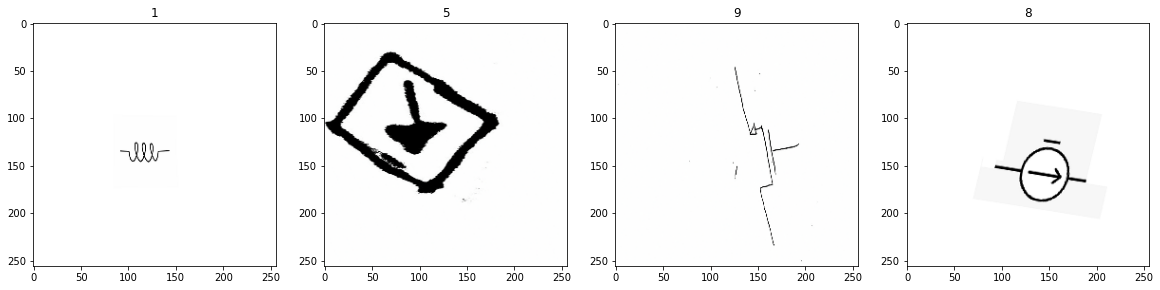

In [287]:
data = tf.keras.utils.image_dataset_from_directory('data',batch_size=50)

data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])


In [288]:
data = data.map(lambda x, y :(x/255,y))


In [289]:
len(data)

2409

In [290]:
train_size=1449
test_size=480
val_size=480

In [291]:

len(data)== (train_size+test_size+val_size)

True

In [292]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


## Deep Learning Model ##

In [293]:
from tensorflow.keras.models  import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense,Flatten,Dropout

In [294]:
from tensorflow.keras.applications.vgg16 import VGG16

In [295]:
vgg16_model = VGG16(pooling='avg',weights='imagenet',include_top=False,input_shape=(256,256,3))
for layers in vgg16_model.layers:
    layers.trainable = False
last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)

vgg_x = Dense(256, activation = 'relu')(vgg_x)
vgg_x = Dense(12, activation = 'softmax')(vgg_x)

vgg16_final_model = tf.keras.Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss = 'sparse_categorical_crossentropy', optimizer= 'adam', metrics=['acc'])



In [296]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",mode="min",patience=0,restore_best_weights=True,verbose=1)
hist = vgg16_final_model.fit(train,epochs=10,validation_data=val,callbacks=[tensorboard_callback,earlystopping])



Epoch 1/10


2022-06-08 19:36:02.363373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 221 of 400
2022-06-08 19:36:06.991501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 355/1449 [======>.......................] - ETA: 2:37:57 - loss: 1.5390 - acc: 0.5459

2022-06-08 20:27:25.430975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities


 792/1449 [===============>..............] - ETA: 1:37:51 - loss: 1.0736 - acc: 0.6886

2022-06-08 21:34:09.379879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities


 919/1449 [==================>...........] - ETA: 1:18:21 - loss: 0.9913 - acc: 0.7137

2022-06-08 21:52:06.307301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities


1115/1449 [======================>.......] - ETA: 49:31 - loss: 0.8893 - acc: 0.7452

2022-06-08 22:21:30.105996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities


1449/1449 [==============================] - ETA: 0s - loss: 0.7600 - acc: 0.7839

2022-06-08 23:09:22.516638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 284 of 400
2022-06-08 23:09:25.509753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-06-08 23:51:06.313990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities
2022-06-09 00:03:28.421585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities
2022-06-09 00:06:46.115331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities
2022-06-09 00:12:12.886445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities
2022-06-09 00:24:33.893556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities
2022-06-09 01:19:40.999342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities


1449/1449 [==============================] - 20940s 14s/step - loss: 0.7600 - acc: 0.7839 - val_loss: 0.2947 - val_acc: 0.9252
Epoch 2/10


2022-06-09 01:25:01.841734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 307 of 400
2022-06-09 01:25:04.401237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 355/1449 [======>.......................] - ETA: 2:23:45 - loss: 0.2695 - acc: 0.9292

2022-06-09 02:11:44.862257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities


 792/1449 [===============>..............] - ETA: 1:26:03 - loss: 0.2412 - acc: 0.9369

2022-06-09 03:08:52.476689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities


 919/1449 [==================>...........] - ETA: 1:09:21 - loss: 0.2337 - acc: 0.9391

2022-06-09 03:25:24.802343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities


1115/1449 [======================>.......] - ETA: 43:39 - loss: 0.2229 - acc: 0.9424

2022-06-09 03:50:52.755905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities


1449/1449 [==============================] - ETA: 0s - loss: 0.2061 - acc: 0.9476

2022-06-09 04:34:34.004167: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 307 of 400
2022-06-09 04:34:36.541053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-06-09 04:45:19.855446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities
2022-06-09 04:57:35.657130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities
2022-06-09 05:00:53.558714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities
2022-06-09 05:06:20.367044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities
2022-06-09 05:18:39.819739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities
2022-06-09 06:13:09.704829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities


Restoring model weights from the end of the best epoch: 2.
1449/1449 [==============================] - 17606s 12s/step - loss: 0.2061 - acc: 0.9476 - val_loss: 0.1442 - val_acc: 0.9642
Epoch 2: early stopping


Okay, after this, I have decided to start thinking up the other sets of data that I would need

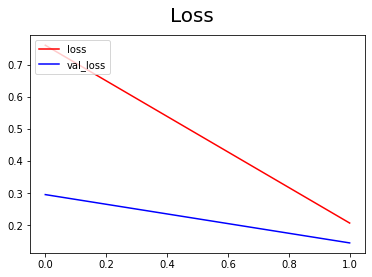

In [297]:
fig = plt.figure()
plt.plot(hist.history['loss'],color='red',label='loss')
plt.plot(hist.history['val_loss'],color='blue',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [298]:
fig = plt.figure()
plt.plot(hist.history['accuracy'],color='red',label='accuracy')

plt.plot(hist.history['val_accuracy'],color='blue',label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc="upper left")
plt.show()

KeyError: 'accuracy'

<Figure size 432x288 with 0 Axes>

In [299]:
precision = Precision()
recall = Recall()
acc = BinaryAccuracy()

In [67]:
for batch in test.as_numpy_iterator():
    X, y = batch

    yhat = np.argmax(vgg16_final_model.predict(np.array(X)))
   

 

2022-06-02 23:21:58.158644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities
2022-06-02 23:22:52.231976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities


1/1 [==============================] - 4s 4s/step


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns

In [ ]:
c_m = confusion_matrix(y,yhat) #c_m stands for confusion matrix

print(c_m)
sns.heatmap(c_m,cmap = "Reds",annot = True,cbar_kws={"orientation":"vertical","label":"color bar "},xticklabels=[0,1],yticklabels=[0,1],fmt ='g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [61]:
print(precision.result().numpy(), recall.result().numpy(), acc.result().numpy())

0.0 0.0 0.0


In [300]:
import cv2

## Saving the model ##

In [384]:
from tensorflow.keras.models import load_model
vgg16_final_model.save(os.path.join('models','multiimageclassifier2.h5'))




In [418]:
new_model = load_model('models/multiimageclassifier2.h5')
model2 = load_model('models/multiimageclassifier.h5')


In [386]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 391ms/step


array([[2.1501009e-03, 4.1288708e-06, 3.3259806e-03, 4.0520267e-03,
        9.7333860e-01, 8.7285629e-03, 2.9677789e-05, 7.1067450e-04,
        4.6828398e-05, 7.5968797e-03, 1.6506601e-05, 1.1020931e-09]],
      dtype=float32)

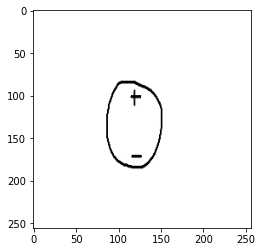

1/1 [==============================] - 0s 191ms/step
Voltage Source
Voltage Source


In [647]:
img = cv2.imread('data/vs/vs28.png')
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

image_class =np.argmax(new_model.predict(np.expand_dims(resize/255, 0)))
image_class2 =np.argmax(model2.predict(np.expand_dims(resize/255, 0)))
added_image_class =np.argmax(0.4*(model2.predict(np.expand_dims(resize/255, 0)))+(0.6*new_model.predict(np.expand_dims(resize/255, 0))))



def numbers_to_label(argument):
    
    switcher = {
        0: "Capacitor",
        1: "Inductor",
        2: "Resistor",
        3: "BJT",
        4: "Diode",
        5: "Dependent Current Source",
        6: "Dependent Voltage Source",
        7: "Ground",
        8: "Current Source",
        9: "MOSFET",
        10: "OP-AMP",
        11: "Voltage Source"

    }
      # get() method of dictionary data type returns
    # value of passed argument if it is present
    # in dictionary otherwise second argument will
    # be assigned as default value of passed argument
    return switcher.get(argument, "nothing")

print(numbers_to_label(image_class))
print(numbers_to_label(image_class2))


